In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch_cka import CKA
import transformers
transformers.logging.set_verbosity_error()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from tqdm import tqdm
from typing import List, Union, Dict

checkpoints_dir = "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/"
directories = os.listdir(checkpoints_dir)
list_models: Dict[str, Union[MBartForConditionalGeneration, MT5ForConditionalGeneration]] = {}
print(f"Loading these models: {directories}")
for i, chckpnt in enumerate(tqdm(directories)):
    if chckpnt.startswith("checkpoint"):
        model_dir = os.path.join(checkpoints_dir, chckpnt)
        list_models[chckpnt] = AutoModelForSeq2SeqLM.from_pretrained(os.path.abspath(model_dir), output_attentions=True)

Loading these models: ['checkpoint-5000', 'checkpoint-10000', 'checkpoint-15000', 'checkpoint-20000', 'checkpoint-25000', 'checkpoint-30000', 'checkpoint-35000', 'checkpoint-40000', 'checkpoint-45000', 'checkpoint-50000', 'checkpoint-55000', 'checkpoint-60000', 'checkpoint-65000', 'checkpoint-70000', 'checkpoint-75000', 'checkpoint-80000', 'checkpoint-85000', 'checkpoint-90000', 'checkpoint-95000', 'checkpoint-100000']


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


In [3]:
from transformers import MBartConfig

tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")
mbart_config = MBartConfig(encoder_layers=6, decoder_layers=6,
                           encoder_ffn_dim=2048, decoder_ffn_dim=2048,
                           encoder_attention_heads=8, decoder_attention_heads=8,
                           d_model=512, max_length=128, vocab_size=tok.vocab_size, dropout=0.1)
random_model: MBartForConditionalGeneration = MBartForConditionalGeneration(mbart_config)

only_ft_model: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_ft_only/checkpoint-100000", output_attentions=True)

last_ft_model = list(list_models.values())[-1]

m1_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000", output_attentions=True)
m2_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)/checkpoint-180000", output_attentions=True)
m3_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)/checkpoint-180000",
    output_attentions=True)
de_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_en-de/checkpoint-180000", output_attentions=True)
col_names = ['(m1, m2)', '(m2, m3)', '(m1, m3)', '(m2, de)', '(m2, rnd)']

In [4]:
from typing import List, Dict, Any
PREFIX_TASK = {'en': "English", 'fr': "French", 'de': "German", 'es': "Spanish"}

def tokenize(examples: List[Dict[str, str]], **kwargs):
    tokenizer = kwargs['tokenizer']
    src_lang: str = kwargs['lang1']
    tgt_lang: str = kwargs['lang2']
    if "task" in kwargs:
        task: str = kwargs['task']
        batch_src: List[str] = [task + e[src_lang] for e in examples]
    else:
        batch_src: List[str] = [e[src_lang] for e in examples]
    batch_tgt: List[str] = [e[tgt_lang] for e in examples]
    # tokenize the batch of sentences
    outputs = tokenizer(batch_src, text_target=batch_tgt, return_special_tokens_mask=False,
                        add_special_tokens=True, truncation=True,
                        max_length=128, padding='max_length',
                        return_attention_mask=False, return_tensors='pt')
    # labels = tokenizer(batch_tgt, truncation=False)
    # batch_tgt = tokenizer.batch_decode(labels['input_ids'], skip_special_tokens=True)

    return {'input_ids': outputs['input_ids'], 'labels': outputs['labels']}

In [7]:
from torch.utils.data import DataLoader
from datasets import Dataset
def create_dataloader(trans_pair_ds: Dataset, input_column: str, fn_kwargs: Dict[str, Any],
                      batch_size: int) -> DataLoader:
    trans_pair_ds = trans_pair_ds.map(tokenize, batched=True, input_columns=[input_column],
                                      fn_kwargs=fn_kwargs)
    # trans_pair_ds = trans_pair_ds.remove_columns(column_names=['translation', 'original_text'])
    trans_pair_ds = trans_pair_ds.with_format('torch', columns=["input_ids", "labels"], output_all_columns=False)

    # ids = [e['input_ids'].view(1, -1) for e in iter(trans_pair_ds)]
    test_loader = DataLoader(trans_pair_ds, num_workers=2, batch_size=batch_size, drop_last=True, pin_memory=False)
    return test_loader
from datasets import load_dataset
from torch.utils.data import DataLoader

wmt14_test = load_dataset("wmt14", "fr-en",
                            cache_dir="/data/n.dallanoce/wmt14",
                            split=f"test",
                            verification_mode='no_checks')

cc_test = load_dataset("yhavinga/ccmatrix", "en-fr",
                                        cache_dir="/data/n.dallanoce/cc_en_fr",
                                        split=f"train[0:3000]",
                                        verification_mode='no_checks')

wmt14_val = load_dataset("wmt14", "fr-en",
                            cache_dir="/data/n.dallanoce/wmt14",
                            split=f"validation",
                            verification_mode='no_checks')

fn_kwargs = {'tokenizer': tok, 'lang1': "en", 'lang2': "fr"}
dataloader_test= create_dataloader(wmt14_test, "translation", fn_kwargs, 32)
dataloader_val = create_dataloader(wmt14_val, "translation", fn_kwargs, 32)
dataloader_cc = create_dataloader(cc_test, "translation", fn_kwargs, 32)

Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset ccmatrix (/data/n.dallanoce/cc_en_fr/yhavinga___ccmatrix/en-fr/1.0.0/5f733aeea277b2b1bb792442ba120c0f7f4b1c7288897051bdf1e9865fe77b93)
Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-8fc61ae01fc78967.arrow
Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-69b9b20e981fc136.arrow
Loading cached processed dataset at /data/n.dallanoce/cc_en_fr/yhavinga___ccmatrix/en-fr/1.0.0/5f733aeea277b2b1bb792442ba120c0f7f4b1c7288897051bdf1e9865fe77b93/cache-3c56a495e623c665.arrow


| Comparing features |: 100%|██████████| 93/93 [00:28<00:00,  3.29it/s]


{(4, 3), (4, 9), (3, 7), (4, 6), (3, 10), (5, 7), (5, 10), (8, 9), (0, 5), (10, 9), (1, 6), (0, 8), (2, 5), (1, 3), (1, 9), (0, 11), (2, 8), (2, 11), (9, 11), (6, 11), (7, 10), (6, 8), (4, 5), (3, 9), (5, 6), (4, 8), (3, 6), (5, 9), (4, 11), (8, 11), (0, 1), (0, 7), (2, 4), (10, 11), (0, 4), (2, 1), (2, 7), (1, 5), (0, 10), (1, 11), (2, 10), (1, 8), (7, 9), (6, 7), (6, 10), (4, 7), (3, 5), (3, 11), (4, 10), (3, 8), (5, 11), (5, 8), (8, 7), (0, 3), (2, 0), (0, 9), (1, 4), (0, 6), (2, 3), (2, 9), (1, 7), (8, 10), (2, 6), (1, 10), (7, 11), (6, 9)}


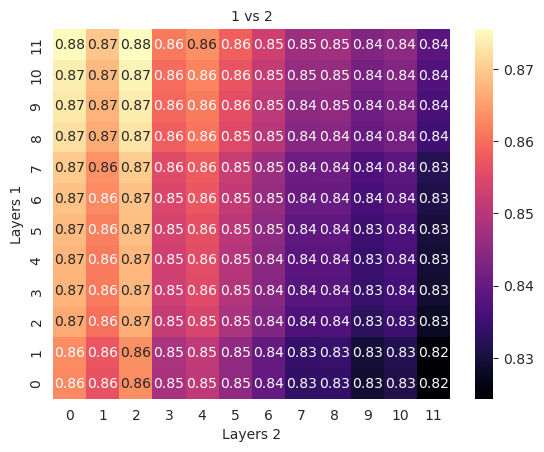

['model.encoder.layers.0.self_attn_layer_norm', 'model.encoder.layers.0.final_layer_norm', 'model.encoder.layers.1.self_attn_layer_norm', 'model.encoder.layers.1.final_layer_norm', 'model.encoder.layers.2.self_attn_layer_norm', 'model.encoder.layers.2.final_layer_norm', 'model.encoder.layers.3.self_attn_layer_norm', 'model.encoder.layers.3.final_layer_norm', 'model.encoder.layers.4.self_attn_layer_norm', 'model.encoder.layers.4.final_layer_norm', 'model.encoder.layers.5.self_attn_layer_norm', 'model.encoder.layers.5.final_layer_norm']
MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(32030, 512, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(32030, 512, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 512)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Li

In [9]:
layers = [f"model.encoder.layers.{i}.self_attn_layer_norm" for i in range(6)] + [f"model.encoder.layers.{i}.final_layer_norm" for i in range(6)]
#layers = [f"model.encoder.layers.{i}.fc1" for i in range(6)] + [f"model.encoder.layers.{i}.fc2" for i in range(6)]
#layers = [f"model.encoder.layers.{i}.self_attn.out_proj" for i in range(6)]
cka = CKA(random_model, m1_model, "1", "2", model1_layers=layers, model2_layers=layers, device="cuda:0")
cka.compare(dataloader_val)
print(cka.sanity_check())
cka.plot_results()
print(cka.model1_info['Layers'])
#print(cka.export()["CKA"])
print(m1_model)

In [ ]:
all_lyrs = list(last_ft_model.named_modules())

In [ ]:
activation = []
def get_activation(name):
    def hook(model, input, output):
      with torch.no_grad():
        activation.append(output)
    return hook

dev = "cpu"
model = last_ft_model.to(dev)
model.model.encoder.layers[0].self_attn.register_forward_hook(get_activation('a'))

In [ ]:
dev = "cpu"
model = last_ft_model.to(dev)
for e in dataloader_test:
  out = last_ft_model(e['input_ids'].to(dev))
  break

In [ ]:
activation[0][0].shape